In [ ]:
!pip install --upgrade tensorflow

In [ ]:
import os
from tensorflow.keras import layers, Input
from tensorflow.keras import Model

In [ ]:
from tensorflow.keras.applications import VGG16

baseModel = VGG16(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
58892288/58889256 [==============================] - 1s 0us/step


In [ ]:
for layer in baseModel.layers:
  layer.trainable = False

In [ ]:
last_layer = baseModel.get_layer('block5_pool')
#print('last layer output shape:', last_layer.output_shape)
last_output = last_layer.output
# print(baseModel.summary())

In [ ]:
from tensorflow.keras.optimizers import RMSprop, SGD

# Flatten the output layer to 1 dimension
headModel = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
headModel = layers.Dense(1024, activation='relu')(headModel)
# Add a dropout rate of 0.2
headModel = layers.Dropout(0.2)(headModel)
# Add a final softmax layer for classification
headModel = layers.Dense(3, activation='softmax')(headModel)

# Configure and compile the model
model = Model(baseModel.input, headModel)
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=0.0001),
              metrics=['acc'])

For examples and data preprocessing, let's use the same files and `train_generator` as we did in Exercise 2.

In [ ]:
"""#!wget --no-check-certificate \
#   https://googledrive.com/host/1xZYahog_Jy93VwbRbXSnJ27QmnfxdBmD/cats_and_dogs_filtered.zip -O \
#   /tmp/cats_and_dogs_filtered.zip
#
"""
import gdown
url ="https://drive.google.com/uc?id=1Nn9v4S5VDn9z2pU2qww5EyHNl_BbIaAH"
output="/tmp/cats_and_dogs_filtered.zip"
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1Nn9v4S5VDn9z2pU2qww5EyHNl_BbIaAH
To: /tmp/cats_and_dogs_filtered.zip
1.25GB [00:08, 143MB/s] 


'/tmp/cats_and_dogs_filtered.zip'

In [ ]:
import zipfile

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# local_zip = '/tmp/cats_and_dogs_filtered.zip'
# zip_ref = zipfile.ZipFile(local_zip, 'r')
# zip_ref.extractall('/tmp')
# zip_ref.close()

# Define our example directories and files
base_dir = '/tmp/data'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir,'test')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our training car pictures
train_cars_dir = os.path.join(train_dir, 'cars')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

# Directory with our validation dog pictures
validation_cars_dir = os.path.join(validation_dir, 'cars')

#Directory to Test folder
test_cats_dir = os.path.join(test_dir,'cats')
test_dogs_dir = os.path.join(test_dir,'dogs')
test_cars_dir = os.path.join(test_dir,'cars')
##########################


train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)
train_car_fnames = os.listdir(train_cars_dir)


# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

# Note that the validation data should not be augmented!
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir, # This is the source directory for training images
        target_size=(224, 224),  # All images will be resized to 224x224
        batch_size=32,
        # Since we use categorical_crossentropy loss, we need binary labels
        class_mode='categorical')

# Flow validation images in batches of 20 using val_datagen generator
validation_generator = val_datagen.flow_from_directory(
        validation_dir,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',
        shuffle=False)

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(224, 224),
        batch_size = 32,
        class_mode='categorical',
        shuffle =False)

Found 15750 images belonging to 3 classes.
Found 2250 images belonging to 3 classes.
Found 4500 images belonging to 3 classes.


Finally, let's train the model using the features we extracted. We'll train on all 15750 images available belongs to 3 classes, for 2 epochs, and validate on all 2250 validation images. Test on 4500 images.

In [ ]:
history = model.fit_generator(
      train_generator,
      epochs=5,
      validation_data=validation_generator,
      verbose=1)
probabilities = model.predict_generator(test_generator)



Epoch 1/5
493/493 [==============================] - 628s 1s/step - loss: 0.3617 - acc: 0.8446 - val_loss: 0.1453 - val_acc: 0.9427
Epoch 2/5
493/493 [==============================] - 616s 1s/step - loss: 0.2494 - acc: 0.8956 - val_loss: 0.1457 - val_acc: 0.9458
Epoch 3/5
493/493 [==============================] - 657s 1s/step - loss: 0.2290 - acc: 0.9060 - val_loss: 0.1308 - val_acc: 0.9529
Epoch 4/5
493/493 [==============================] - 650s 1s/step - loss: 0.2192 - acc: 0.9072 - val_loss: 0.1211 - val_acc: 0.9556
Epoch 5/5
493/493 [==============================] - 617s 1s/step - loss: 0.2089 - acc: 0.9142 - val_loss: 0.2017 - val_acc: 0.9204


In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

y_true = test_generator.classes
y_pred = np.argmax(probabilities, axis=-1)
#y_pred_bool = np.argmax(y_pred, axis=1)

confuse = confusion_matrix(y_true, y_pred)
print(confuse)
print("Precision: ",precision_score(y_true, y_pred, average = 'macro'))
print("Recall: ",recall_score(y_true, y_pred, average = 'macro'))
print("F1: ",f1_score(y_true, y_pred, average = 'macro' ))

[[1490    0   10]
 [   0 1190  310]
 [   0   25 1475]]
Precision:  0.9337169626037882
Recall:  0.9233333333333333
F1:  0.9228542797752292


Text(0.5, 1.0, 'Training and validation loss')

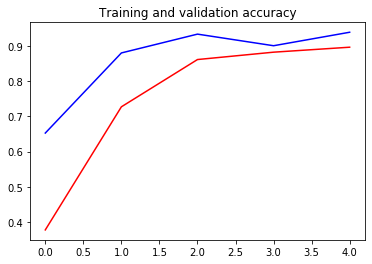

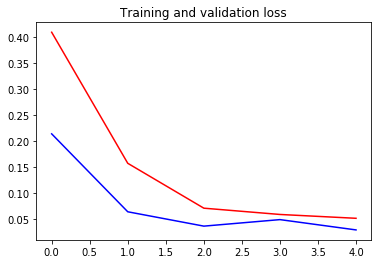

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Retrieve a list of accuracy results on training and validation data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of list results on training and validation data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc,"r")
plt.plot(epochs, val_acc,"b")
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss,"r")
plt.plot(epochs, val_loss,"b")
plt.title('Training and validation loss')

## Clean Up

Run the following cell to terminate the kernel and free memory resources:

In [ ]:
import os, signal
os.kill(os.getpid(), signal.SIGKILL)